# Verificación de uso de GPU para más velocidad

In [1]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Importación del DataSet


In [4]:
# Instalar kagglehub
!pip install kagglehub --quiet

# Descargar y verificar dataset
import kagglehub
import os

# Descargar dataset desde Kaggle
original_path = kagglehub.dataset_download("raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables")
print(" Dataset descargado en:", original_path)

✅ Dataset descargado en: /kaggle/input/fresh-and-stale-images-of-fruits-and-vegetables


In [5]:
# Reorganizar dataset a clasificación binaria con división train/val/test
import shutil
import random

new_path = "/content/dataset_binario"
splits = ['train', 'val', 'test']
class_map = {'fresh': [], 'stale': []}

# Detectar carpetas fresh/stale
for folder in os.listdir(original_path):
    if folder.startswith('fresh'):
        class_map['fresh'].append(folder)
    elif folder.startswith('stale'):
        class_map['stale'].append(folder)

# Crear carpetas destino
for split in splits:
    for clase in ['fresh', 'stale']:
        os.makedirs(os.path.join(new_path, split, clase), exist_ok=True)

# Dividir imágenes y copiar
for clase, folders in class_map.items():
    all_images = []
    for folder in folders:
        folder_path = os.path.join(original_path, folder)
        for img in os.listdir(folder_path):
            all_images.append(os.path.join(folder_path, img))

    random.shuffle(all_images)
    total = len(all_images)
    train_split = int(0.7 * total)
    val_split = int(0.85 * total)

    for i, img_path in enumerate(all_images):
        if i < train_split:
            destino = os.path.join(new_path, 'train', clase)
        elif i < val_split:
            destino = os.path.join(new_path, 'val', clase)
        else:
            destino = os.path.join(new_path, 'test', clase)
        shutil.copy(img_path, os.path.join(destino, os.path.basename(img_path)))

print(" Dataset reorganizado correctamente en:", new_path)


✅ Dataset reorganizado correctamente en: /content/dataset_binario


In [6]:
# Preparar generadores de datos
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(new_path, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['fresh', 'stale']
)

val_generator = test_datagen.flow_from_directory(
    os.path.join(new_path, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['fresh', 'stale']
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(new_path, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    classes=['fresh', 'stale']
)


Found 10276 images belonging to 2 classes.
Found 2203 images belonging to 2 classes.
Found 2203 images belonging to 2 classes.


#Entrenamiento con MobileNetV2


In [7]:
# Construir y entrenar modelo con MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Transfer learning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 196s 572ms/step - accuracy: 0.5876 - loss: 0.7188 - val_accuracy: 0.8293 - val_loss: 0.4348
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 171s 531ms/step - accuracy: 0.8165 - loss: 0.4276 - val_accuracy: 0.8788 - val_loss: 0.3291
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 175s 542ms/step - accuracy: 0.8726 - loss: 0.3316 - val_accuracy: 0.8961 - val_loss: 0.2817
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 171s 530ms/step - accuracy: 0.8907 - loss: 0.2838 - val_accuracy: 0.9060 - val_loss: 0.2512
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 170s 529ms/step - accuracy: 0.9081 - loss: 0.2523 - val_accuracy: 0.9151 - val_loss: 0.2284
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 169s 525ms/step - accuracy: 0.9169 - loss: 0.2259 - val_accuracy: 0.9215 - val_loss: 0.2100
Epoch 7/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 173s 538ms/step - accuracy: 0.9266 - loss: 0.2066 - val_accuracy: 0.9233 - val_loss: 0.2006
Epoch 8/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 169s 526ms/step - accuracy: 0.9277 -

In [8]:
# Evaluación final en test set
loss, acc = model.evaluate(test_generator)
print(f"\n Precisión en test: {acc:.2%} | Pérdida: {loss:.4f}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.8836 - loss: 0.2633

✅ Precisión en test: 92.69% | Pérdida: 0.1734


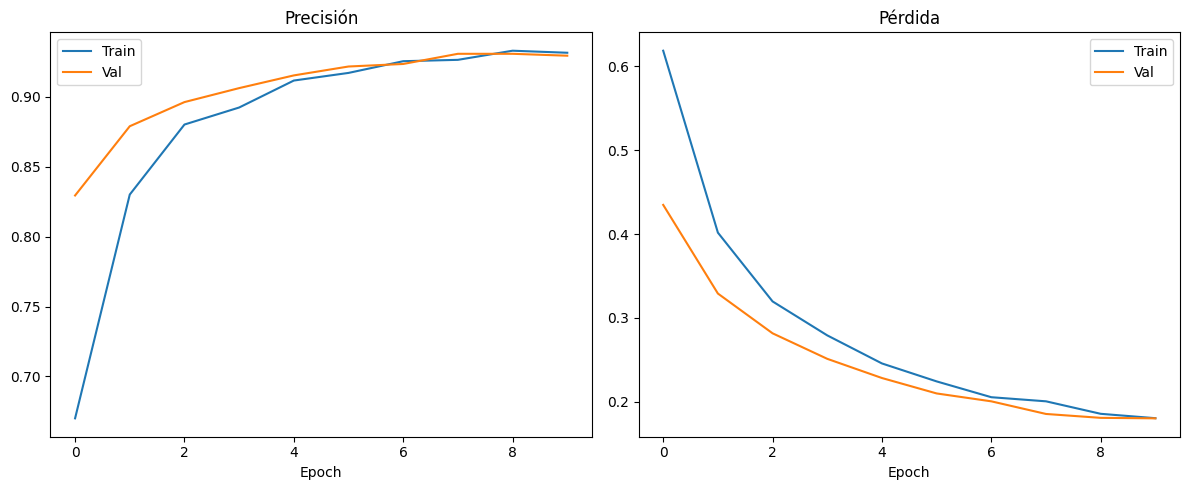

In [9]:
# Visualización de métricas de entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Precisión')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Pérdida')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step


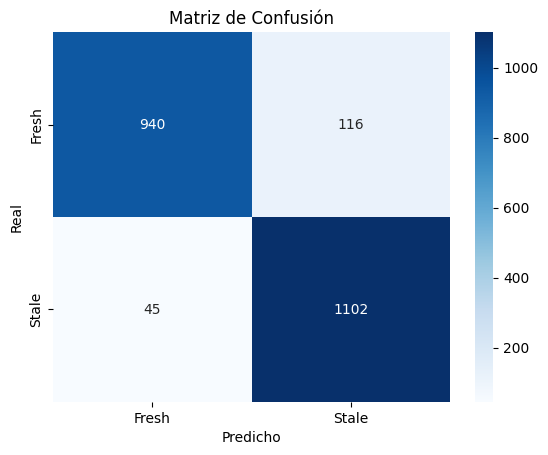

              precision    recall  f1-score   support

       Fresh       0.95      0.89      0.92      1056
       Stale       0.90      0.96      0.93      1147

    accuracy                           0.93      2203
   macro avg       0.93      0.93      0.93      2203
weighted avg       0.93      0.93      0.93      2203



In [10]:
# Matriz de confusión y métricas
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fresh", "Stale"], yticklabels=["Fresh", "Stale"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Fresh", "Stale"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


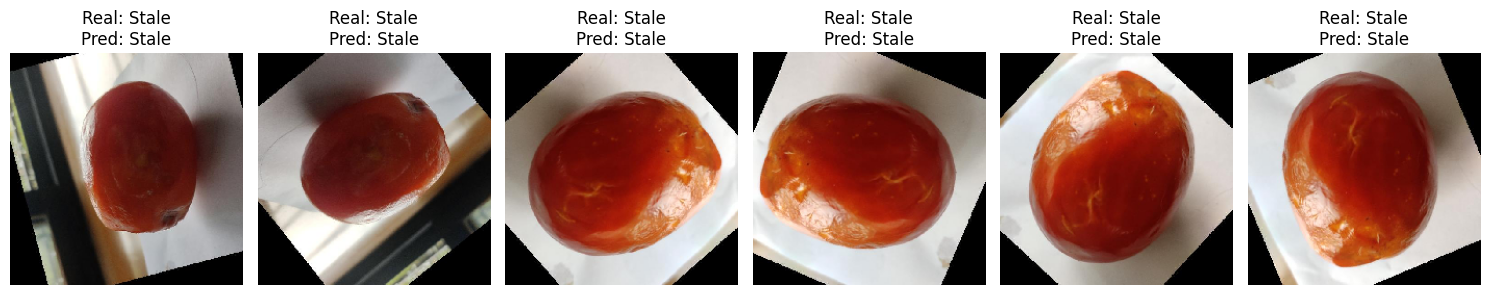

In [51]:
# Mostrar imágenes con predicción real vs estimada
def mostrar_predicciones(num=6):
    x_batch, y_batch = next(test_generator)
    class_map = {0: "Fresh", 1: "Stale"}

    plt.figure(figsize=(15,5))
    for i in range(num):
        img = x_batch[i]
        real = int(y_batch[i])
        pred_prob = model.predict(np.expand_dims(img, axis=0))[0][0]
        pred = int(pred_prob > 0.5)

        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(f"Real: {class_map[real]}\nPred: {class_map[pred]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

mostrar_predicciones()


In [29]:
# Guardar modelo final
model.save("modelo_fresh_vs_stale_mobilenet.h5")
print(" Modelo guardado como modelo_fresh_vs_stale_mobilenet.h5")


✅ Modelo guardado como modelo_fresh_vs_stale_mobilenet.h5


# Entrenamiento con CNN personalizada


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # salida binaria
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 180s 539ms/step - accuracy: 0.6860 - loss: 0.5659 - val_accuracy: 0.8629 - val_loss: 0.2961
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 167s 520ms/step - accuracy: 0.8570 - loss: 0.3179 - val_accuracy: 0.8597 - val_loss: 0.3107
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 168s 523ms/step - accuracy: 0.8825 - loss: 0.2683 - val_accuracy: 0.9010 - val_loss: 0.2021
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 168s 521ms/step - accuracy: 0.9046 - loss: 0.2243 - val_accuracy: 0.9265 - val_loss: 0.1932
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 172s 535ms/step - accuracy: 0.9161 - loss: 0.2081 - val_accuracy: 0.9201 - val_loss: 0.1886
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 170s 526ms/step - accuracy: 0.9209 - loss: 0.1936 - val_accuracy: 0.9392 - val_loss: 0.1506
Epoch 7/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 171s 530ms/step - accuracy: 0.9339 - loss: 0.1626 - val_accuracy: 0.9510 - val_loss: 0.1261
Epoch 8/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 171s 532ms/step - accuracy: 0.9357 -

In [32]:
loss_cnn, acc_cnn = cnn_model.evaluate(test_generator)
print(f" CNN personalizada - Precisión en test: {acc_cnn:.2%} | Pérdida: {loss_cnn:.4f}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9680 - loss: 0.1071
✅ CNN personalizada - Precisión en test: 97.05% | Pérdida: 0.0941


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


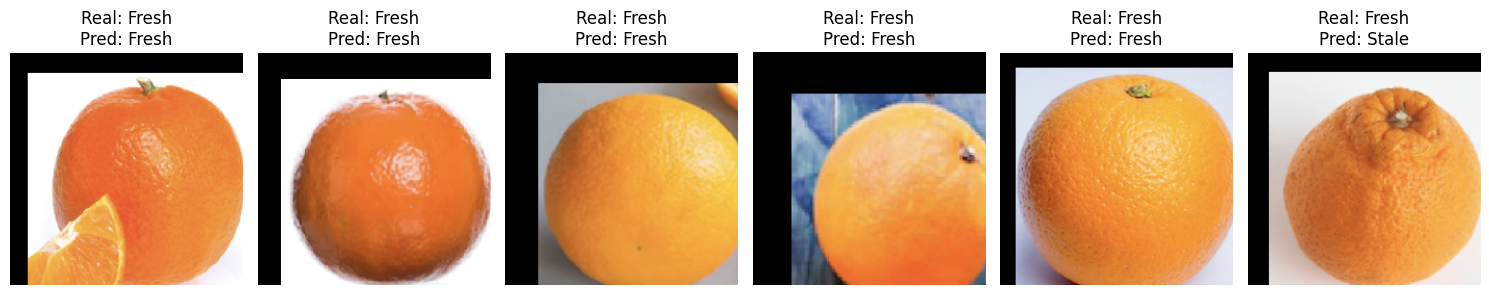

In [46]:
def mostrar_predicciones_cnn(num=6):
    x_batch, y_batch = next(test_generator)
    class_map = {0: "Fresh", 1: "Stale"}

    plt.figure(figsize=(15,5))
    for i in range(num):
        img = x_batch[i]
        real = int(y_batch[i])
        pred_prob = cnn_model.predict(np.expand_dims(img, axis=0))[0][0]
        pred = int(pred_prob > 0.5)

        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(f"Real: {class_map[real]}\nPred: {class_map[pred]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#  Llamada
mostrar_predicciones_cnn()


69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step


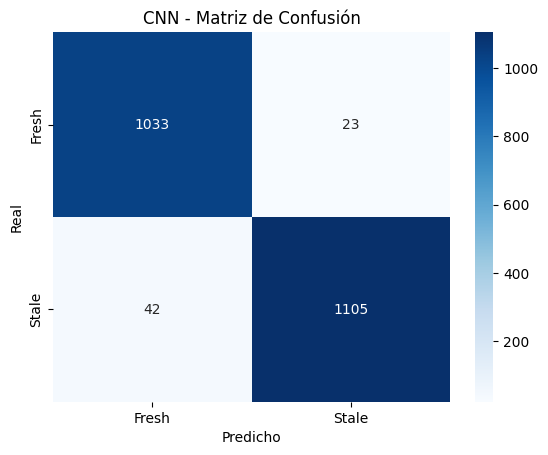

              precision    recall  f1-score   support

       Fresh       0.96      0.98      0.97      1056
       Stale       0.98      0.96      0.97      1147

    accuracy                           0.97      2203
   macro avg       0.97      0.97      0.97      2203
weighted avg       0.97      0.97      0.97      2203



In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

y_true = test_generator.classes
y_pred_probs = cnn_model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fresh", "Stale"], yticklabels=["Fresh", "Stale"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("CNN - Matriz de Confusión")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Fresh", "Stale"]))


In [47]:
cnn_model.save("modelo_fresh_vs_stale_cnn.h5")
print(" Modelo CNN personalizado guardado como modelo_fresh_vs_stale_cnn.h5")


✅ Modelo CNN personalizado guardado como modelo_fresh_vs_stale_cnn.h5
